# MIS Divergence

In [1]:
import numpy as np
import math
from scipy import integrate, stats
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "amsmath",
    "font.sans-serif": "Helvetica",
})

## Generic part

In [3]:
# balance heuristic divergence
def bh_div(alpha, p1, p2):
    return alpha * p1 + (1 - alpha) * p2

def bh_div_weight(alpha, p1, p2):
    return (alpha * p1) / (alpha * p1 + (1 - alpha) * p2)

In [54]:
# computed variance for specific method
# TODO : check variance V[F] formula
def var_method(samples, fpdfs, gpdfs, alpha):
    
    v_sum_squared = 0
    v_sum = 0
    
    for i, spp in enumerate(samples):
        
        v_sum_squared += (spp ** 2) / (bh_div(alpha, fpdfs[i], gpdfs[i]) ** 2)
        v_sum += (spp / bh_div(alpha, fpdfs[i], gpdfs[i]))
        
    v_sum_squared /= len(samples)
    v_sum /= len(samples)
    
    
    print(v_sum_squared)
    print(v_sum)
    print("-----")
    
    return alpha * (v_sum_squared - (v_sum ** 2))

def sample(f, sampling1, sampling2, pdf_f1, pdf_f2, alpha):
    
    f_sum = 0
    
    # sample using first method
    x1 = sampling1()
    
    fpdf_1 = pdf_f1(x1)
    gpdf_1 = pdf_f2(x1)
    
    f1 = f(x1)
    
    f_sum += f1 * bh_div_weight(alpha, fpdf_1, gpdf_1)
    
    # sample using second method
    x2 = sampling2()
    
    # TODO: reverse PDFs or not?
    fpdf_2 = pdf_f2(x2)
    gpdf_2 = pdf_f1(x2)
    
    f2 = f(x2)
    
    f_sum += f2 * bh_div_weight(1 - alpha, fpdf_2, gpdf_2)
    
    return f_sum, f1, f2, fpdf_1, gpdf_1, fpdf_2, gpdf_2 

### Example 1

In [5]:
def example_1(x):
    return math.sqrt(x) + math.sin(x)

In [6]:
# get example1 intergal from [0.01, 3.5 * \pi] of PDFs
I = integrate.quad(example_1, 0.01, 3.5 * math.pi) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 25.306521511962696


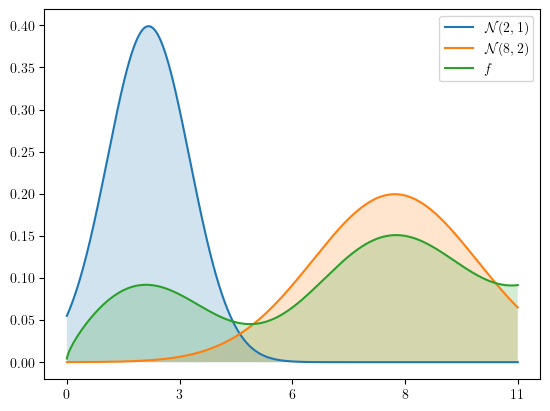

In [7]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(0.01, 3.5 * math.pi, n_spp)
x = np.arange(n_spp)

f1_pdfs = stats.norm.pdf(samples, 2, 1)
f2_pdfs = stats.norm.pdf(samples, 8, 2)
example_samples = np.array([ example_1(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(2, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(8, 2)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")
plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency=250
plt.xticks(x[::frequency], [ f"{xi:.0f}" for xi in samples[::frequency]] )
plt.legend()

### Example 2

In [8]:
def example_2(x):
    return stats.norm.pdf(x, -1.5, 1) + 2 * stats.norm.pdf(x, 1.5, 0.75)

def example_2_func(x):
    return x + 2 * x

In [9]:
# get example2 intergal from [-4, 4] of PDFs
I = integrate.quad(example_2, -4, 4) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 2.9929321950180436


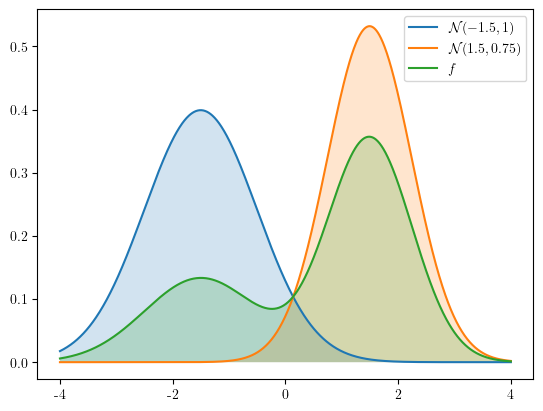

In [10]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(-4, 4.01, n_spp)
x = np.arange(n_spp)

f1_pdfs = stats.norm.pdf(samples, -1.5, 1)
f2_pdfs = stats.norm.pdf(samples, 1.5, 0.75)
example_samples = np.array([ example_2(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(-1.5, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(1.5, 0.75)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")
plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency=250
plt.xticks(x[::frequency], [ f"{xi:.0f}" for xi in samples[::frequency]] )
plt.legend()

### Prepare MIS (equal sampling) for example 2

In [11]:
f1 = lambda: np.random.normal(-1.5, 1)
f2 = lambda: np.random.normal(1.5, 0.75)
pdf_f1 = lambda x: stats.norm.pdf(x, -1.5, 1)
pdf_f2 = lambda x: stats.norm.pdf(x, 1.5, 0.75)
alpha = 0.5

In [55]:
s_list = []
f1_list = []
f2_list = []
fpdf1_list = []
gpdf1_list = []
fpdf2_list = []
gpdf2_list = []

for i in range(100000):
    
    # TODO : check how we need to sample (function or pdf function)
    s, f1_s, f2_s, fpdf1, gpdf1, fpdf2, gpdf2 = sample(example_2, f1, f2, pdf_f1, pdf_f2, alpha)
    
    s_list.append(s)
    f1_list.append(f1_s)
    f2_list.append(f2_s)
    fpdf1_list.append(fpdf1)
    gpdf1_list.append(gpdf1)
    fpdf2_list.append(fpdf2)
    gpdf2_list.append(gpdf2)

In [56]:
VF_sum = 0

# TODO : check variance method computation using final sample or method sample 
VF_sum += var_method(f1_list, fpdf1_list, gpdf1_list, 0.5)
VF_sum += var_method(f2_list, fpdf2_list, gpdf2_list, 0.5)
print(VF_sum)

4.662599274554612
2.128589093168289
-----
15.074399560766135
3.8704176862751907
-----
0.11298712076697415


In [40]:
# other links
# https://github.com/MJeremy2017/machine-learning-algorithm-implemention/blob/master/ImportanceSampling/ImportanceSampling.ipynb